In [83]:
# Import libraries
import os
import tarfile
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import scipy
from scipy import stats
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Download data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

# Load data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# Read data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


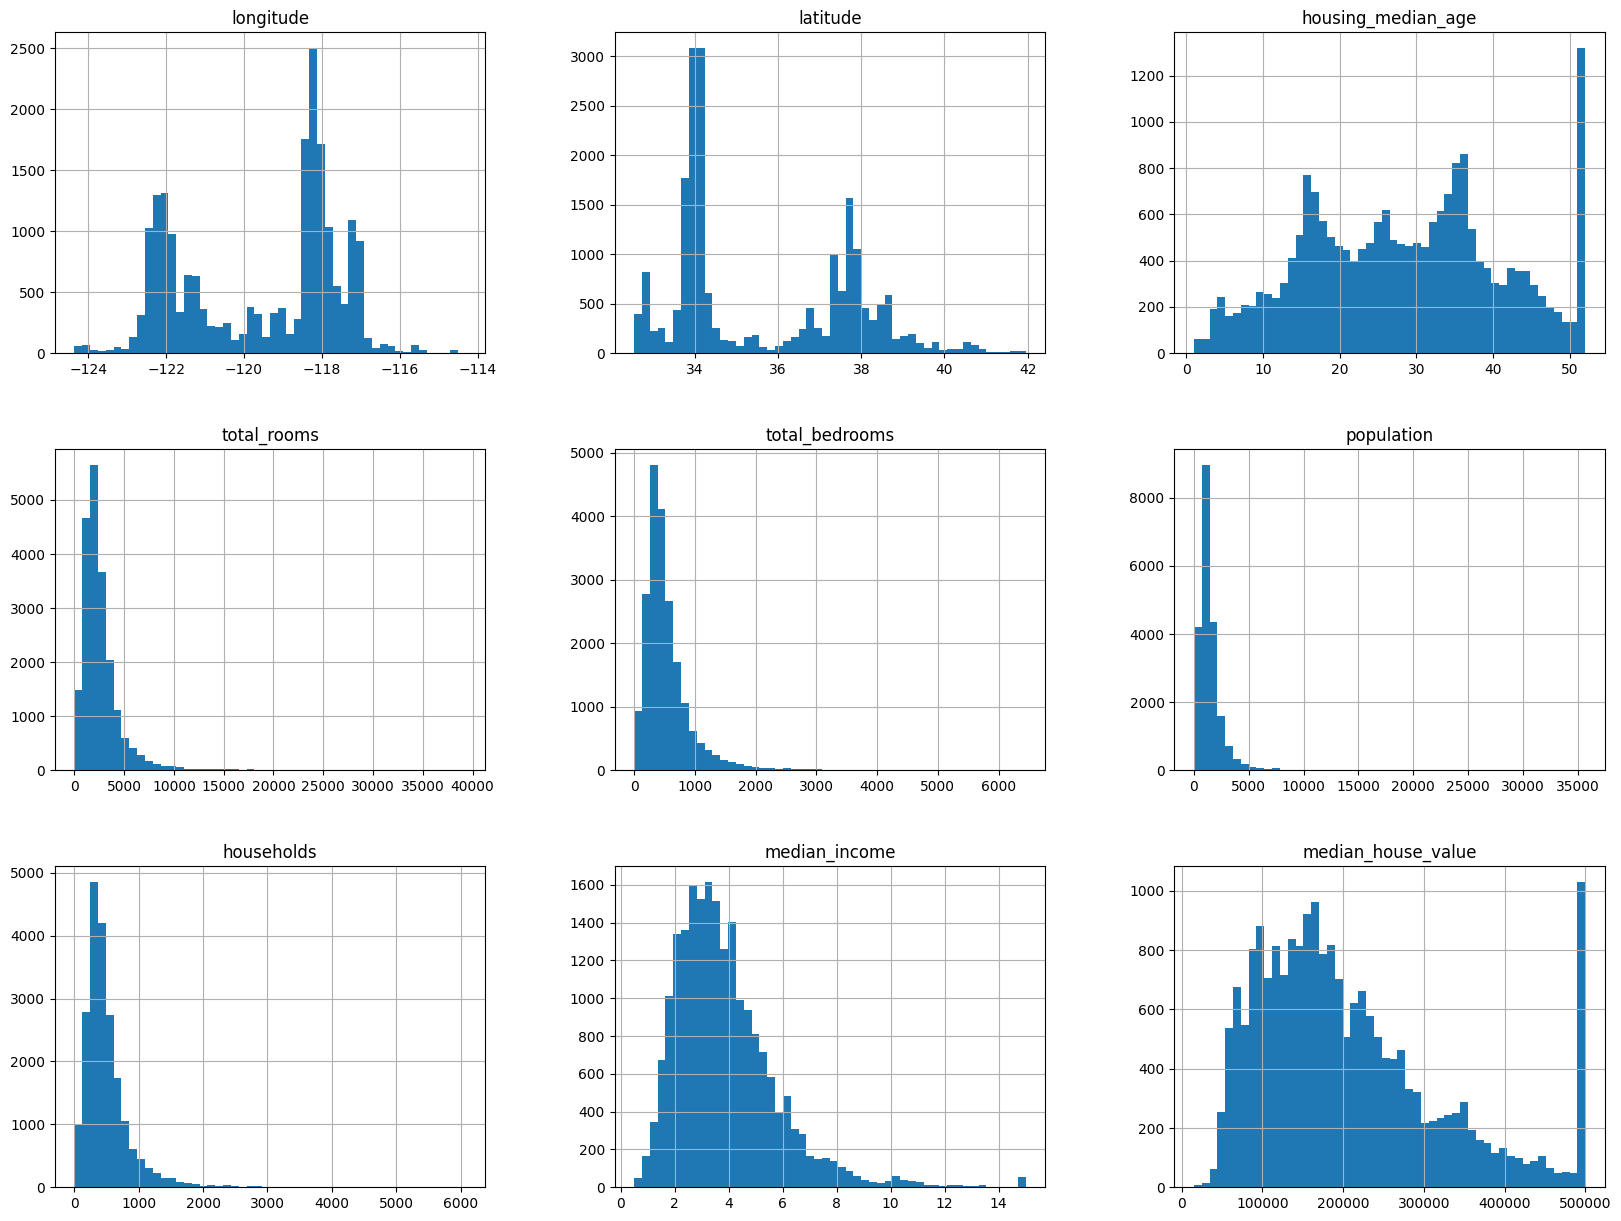

In [7]:
# Histograms of numeric data
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# Create a test set using random sampling method
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=10)
print('Train set length:', len(train_set))
print('Test set length: ', len(test_set))

Train set length: 16512
Test set length:  4128


<AxesSubplot: >

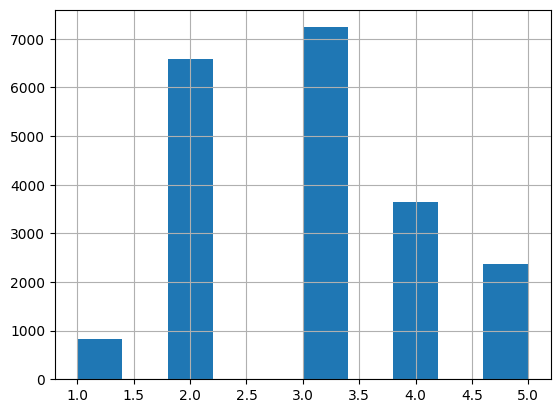

In [9]:
# Check amount of data for different stratum
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

housing['income_cat'].hist()

In [10]:
# Create a test set using stratified sampling method
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#Check income category proportions in the test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [11]:
# Remove income_cat attribute and set data back into its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [12]:
# Make a copy to preserve the training set
housing = strat_train_set.copy()

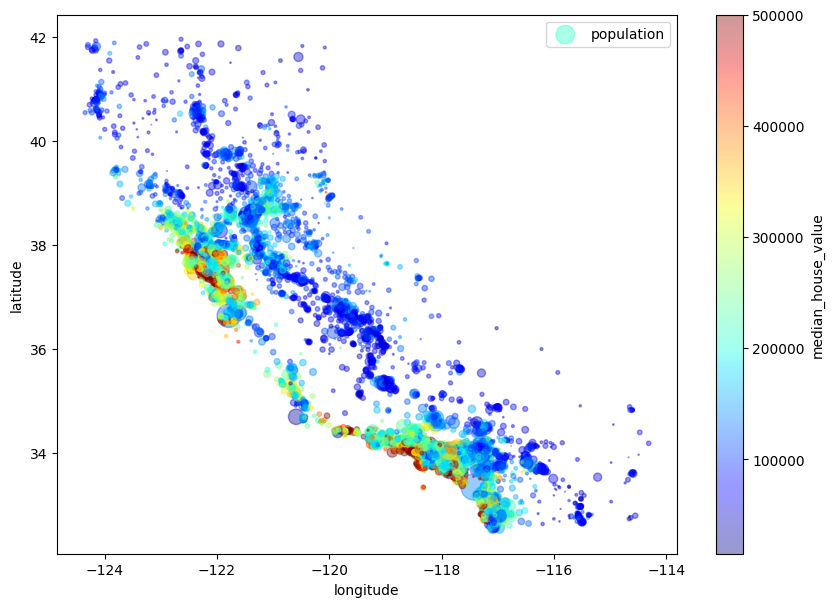

In [13]:
# Visualizing geographic data
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [23]:
# Looking for correlations
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688214
total_rooms           0.133785
housing_median_age    0.105336
households            0.065036
total_bedrooms        0.048016
population           -0.025355
longitude            -0.047002
latitude             -0.142754
Name: median_house_value, dtype: float64

array([[<AxesSubplot: xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot: xlabel

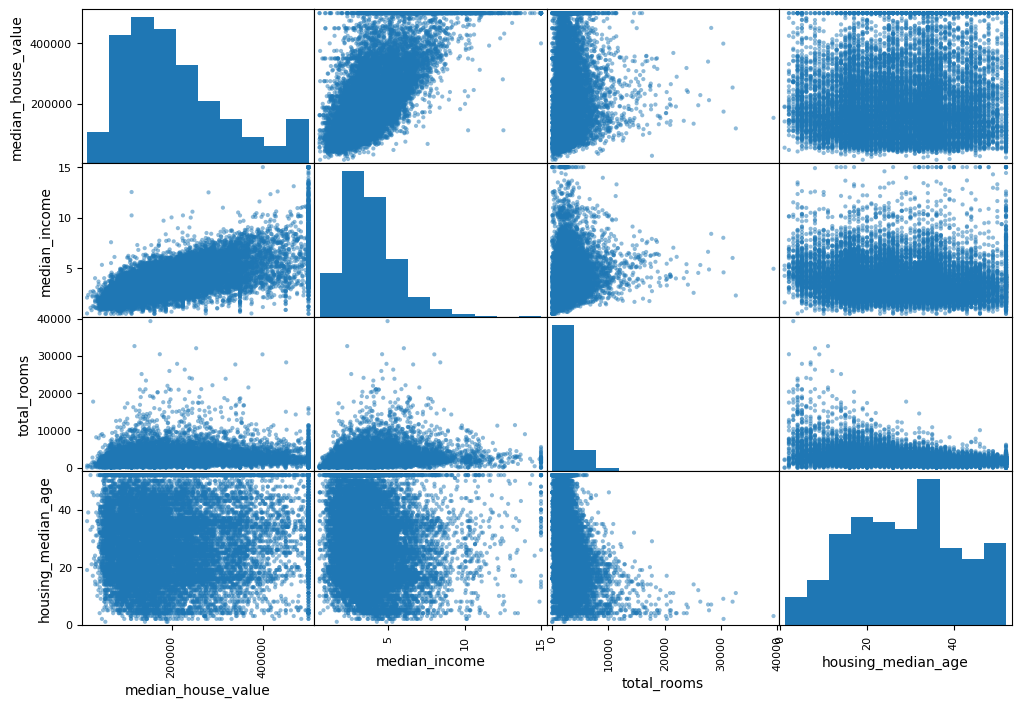

In [14]:
# Check correlations using scatter matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

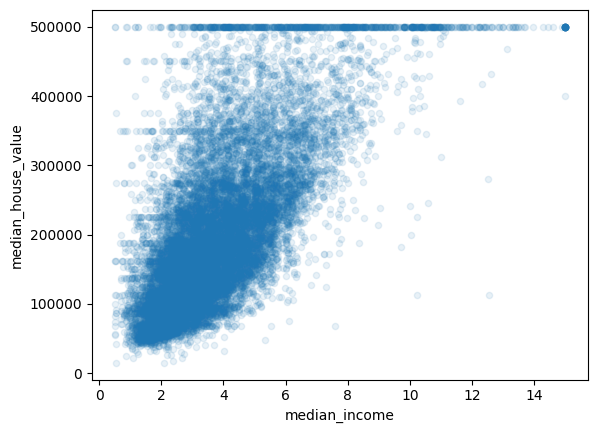

In [15]:
# Correlation plot for median income versus median house value
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [16]:
# Expand data
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [17]:
# Looking for correlations
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688214
rooms_per_household         0.150724
total_rooms                 0.133785
housing_median_age          0.105336
households                  0.065036
total_bedrooms              0.048016
population                 -0.025355
population_per_household   -0.033178
longitude                  -0.047002
latitude                   -0.142754
bedrooms_per_room          -0.254370
Name: median_house_value, dtype: float64

In [18]:
# Revert to a clean training set
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [25]:
# Check columns with missing values
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 6229 to 10003
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16351 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [47]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [45]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [48]:
# Numeric data transformation
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [49]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), ("cat", OneHotEncoder(), cat_attribs),])
housing_prepared = full_pipeline.fit_transform(housing)

In [52]:
# Train Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [53]:
# Test Linear Regression Model
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [214459.36451969 300596.64982337 131918.57476666 244540.28908094
 202375.68394314]
Labels: [210200.0, 274600.0, 131500.0, 250600.0, 194600.0]


In [55]:
# Calculate RMSE of Linear Regression Model
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68306.36120311666

In [57]:
# Train Decision Tree Regressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [59]:
# Test Decision Tree Regression Model
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [61]:
# Cross-validate Decision Tree Regression Model scores
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [62]:
# Check results
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69338.84883517 73276.98754422 70055.08460246 71495.1104361
 73447.64406338 69346.92886134 69693.21790774 70996.29731804
 73656.76500941 70920.70247405]
Mean: 71222.7587051915
Standard deviation: 1614.9881647803586


In [63]:
# Cross-validate Linear Regression Model scores
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [70360.23685555 67848.8696317  72474.7822004  70716.02600949
 69240.17392851 66820.52149041 70667.29229049 66107.39132076
 66660.64000638 66082.33162871]
Mean: 68697.82653624036
Standard deviation: 2173.0477803974663


In [65]:
# Train Random Forest Regression Model
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [66]:
# Test Random Forest Regression Model
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18688.01493882113

In [67]:
# Cross-validate Random Forest Regression Model scores
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [50132.01935348 49583.5582902  50854.72316519 51403.04518191
 52466.28193739 48009.27906006 49171.34862616 50119.02224058
 49715.31998599 48632.12040042]
Mean: 50008.6718241379
Standard deviation: 1248.505964400951


In [69]:
# Improve model using Grid Search
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [70]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [71]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [72]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

62555.77599266448 {'max_features': 2, 'n_estimators': 3}
54753.25769687378 {'max_features': 2, 'n_estimators': 10}
53012.778621171914 {'max_features': 2, 'n_estimators': 30}
60043.02646374029 {'max_features': 4, 'n_estimators': 3}
52898.51826949205 {'max_features': 4, 'n_estimators': 10}
50628.628809006994 {'max_features': 4, 'n_estimators': 30}
59160.612394221804 {'max_features': 6, 'n_estimators': 3}
52072.08226146823 {'max_features': 6, 'n_estimators': 10}
49895.04451876516 {'max_features': 6, 'n_estimators': 30}
59248.75026086854 {'max_features': 8, 'n_estimators': 3}
51777.638094104484 {'max_features': 8, 'n_estimators': 10}
50050.38880061146 {'max_features': 8, 'n_estimators': 30}
62839.11595525036 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54227.62047703606 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59779.630766932874 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51964.06677206569 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [74]:
# Improve model using Randomized Search
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]
forest_reg = RandomForestRegressor()
randomized_search = RandomizedSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
randomized_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_features': [2, 4, 6, 8],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [75]:
randomized_search.best_params_

{'n_estimators': 30, 'max_features': 6}

In [76]:
randomized_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [77]:
cvres = randomized_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

60261.470815643566 {'n_estimators': 3, 'max_features': 3, 'bootstrap': False}
50012.947038062 {'n_estimators': 30, 'max_features': 6}
50303.401092123415 {'n_estimators': 30, 'max_features': 4}
52322.459605897515 {'n_estimators': 10, 'max_features': 4}
62531.64922227922 {'n_estimators': 3, 'max_features': 2}
50074.37649724255 {'n_estimators': 30, 'max_features': 8}
54202.924524388545 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}
59522.12790011649 {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
52271.685589802386 {'n_estimators': 10, 'max_features': 3, 'bootstrap': False}
52436.147709368226 {'n_estimators': 30, 'max_features': 2}


In [78]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.50524620e-02, 6.76328125e-02, 4.37271649e-02, 1.72360005e-02,
       1.75060266e-02, 1.82101062e-02, 1.58515078e-02, 3.21694963e-01,
       5.15860529e-02, 1.06136153e-01, 9.20261504e-02, 7.58235447e-03,
       1.60128162e-01, 1.88617529e-04, 2.22475174e-03, 3.21671429e-03])

In [80]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3216949630292348, 'median_income'),
 (0.16012816192320273, 'INLAND'),
 (0.1061361532557138, 'pop_per_hhold'),
 (0.09202615041640654, 'bedrooms_per_room'),
 (0.07505246202345106, 'longitude'),
 (0.0676328124710989, 'latitude'),
 (0.05158605293447825, 'rooms_per_hhold'),
 (0.04372716485121855, 'housing_median_age'),
 (0.01821010616953062, 'population'),
 (0.0175060266282066, 'total_bedrooms'),
 (0.01723600048562424, 'total_rooms'),
 (0.015851507786167476, 'households'),
 (0.007582354467445526, '<1H OCEAN'),
 (0.0032167142868996124, 'NEAR OCEAN'),
 (0.002224751742525009, 'NEAR BAY'),
 (0.00018861752879632864, 'ISLAND')]

In [82]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48918.490051614775

In [84]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46749.05441033, 50995.71795357])